# Plotting Prophet Forecasts

Visual comparison of how well prophet fits the actual data.

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from prophet import Prophet
import matplotlib.pyplot as plt


def load_data(filepath, chunk=None):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Convert all columns (except date) to numeric
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by date
    df = df.sort_values(by='date').reset_index(drop=True)

    # Optionally aggregate by week or month
    if chunk in ['week', 'month']:
        df = df.set_index('date')

        if chunk == 'week':
            df = df.resample('W').mean()
        elif chunk == 'month':
            df = df.resample('M').mean()

        df = df.reset_index()

    return df

def plot_actual_vs_prophet(df, pollutant, train_start, train_end, predict_end):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    
    # Clean and interpolate
    df = df[['date', pollutant]].set_index('date').asfreq('D')
    df[pollutant] = df[pollutant].interpolate(limit_direction='both')
    df = df.reset_index()

    # Fit Prophet
    model_df = df[(df['date'] >= train_start) & (df['date'] <= train_end)].copy()
    model_df.rename(columns={'date': 'ds', pollutant: 'y'}, inplace=True)
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(model_df)

    future = pd.DataFrame({'ds': pd.date_range(start=train_start, end=predict_end, freq='D')})
    forecast = model.predict(future)
    forecast = forecast[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': f'{pollutant}_prediction'})

    # Merge and plot
    merged = pd.merge(df[['date', pollutant]], forecast, on='date', how='inner')

    plt.figure(figsize=(14, 5))
    plt.plot(merged['date'], merged[pollutant], label='Actual', color='black', alpha=0.6)
    plt.plot(merged['date'], merged[f'{pollutant}_prediction'], label='Prophet Prediction', color='blue')
    plt.axvline(pd.to_datetime(train_end), color='gray', linestyle='--', label='Train End')
    plt.title(f"{pollutant.upper()} – Actual vs Prophet Prediction")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

10:31:41 - cmdstanpy - INFO - Chain [1] start processing
10:31:41 - cmdstanpy - INFO - Chain [1] done processing


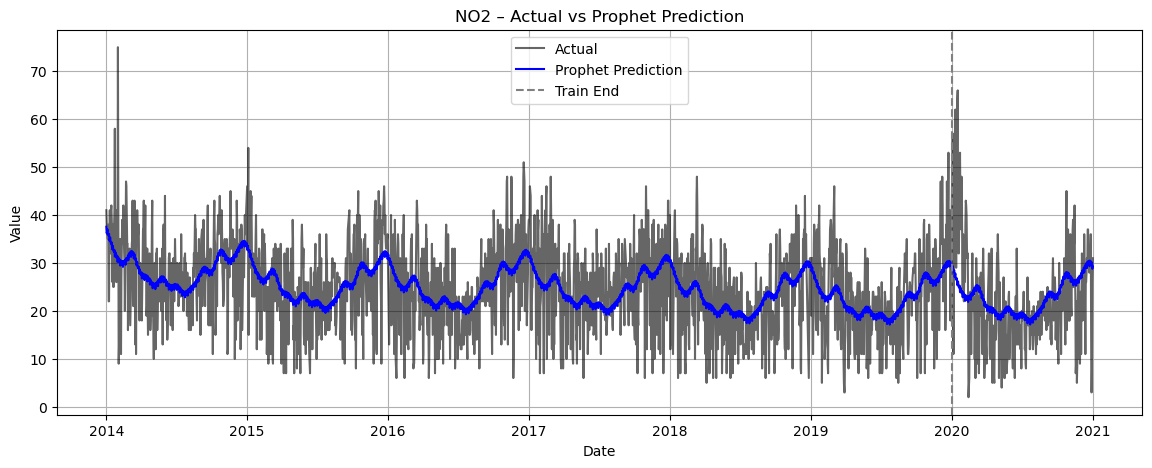

In [2]:
city_df = load_data("aqicn_data/baotou.csv", chunk='day')

plot_actual_vs_prophet(
    df=city_df,
    pollutant='no2',
    train_start='2014-01-01',
    train_end='2020-01-01',
    predict_end='2021-01-01'
)